# Credit Card Fraud Detection Using Autoencoder

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива?

### Автокодировщик

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg?w=638&ssl=1" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

## Declare required dependencies

In [71]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Diabetes"]

## Data ingestion

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Университет/Технологии машинного обучения и нейросети для решения прикладных задач/Лаб №7/data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

## Data exploration

In [5]:
pd.set_option('display.max_columns', None)
df.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [6]:
# нормализуем числовые данные

from sklearn.preprocessing import MinMaxScaler  # StandardScaler

scaler_mm = MinMaxScaler()

for i in df.columns:
  df[df.columns] = scaler_mm.fit_transform(df[df.columns])
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,0.162791,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.50,0.166667,1.000000,0.0,1.0,0.250000,1.0,1.0
1,0.0,1.0,1.0,1.0,0.162791,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.50,0.000000,0.000000,0.0,1.0,0.916667,1.0,1.0
2,0.0,0.0,0.0,1.0,0.162791,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.000000,0.333333,0.0,1.0,1.000000,1.0,1.0
3,0.0,1.0,1.0,1.0,0.186047,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.50,0.000000,0.100000,0.0,1.0,0.833333,1.0,1.0
4,0.0,0.0,0.0,1.0,0.197674,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.583333,0.8,1.0


In [8]:
print(df.shape)
df.describe()

(70692, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,0.207639,0.475273,0.062171,0.147810,0.703036,0.611795,0.788774,0.042721,0.954960,0.093914,0.459270,0.125068,0.193681,0.252730,0.456997,0.632005,0.784191,0.671187
std,0.500004,0.495960,0.499342,0.155336,0.082720,0.499392,0.241468,0.354914,0.456924,0.487345,0.408181,0.202228,0.207394,0.291712,0.278391,0.271854,0.335409,0.434581,0.498151,0.237679,0.205816,0.310742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.151163,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.500000,0.600000,0.428571
50%,0.500000,1.000000,1.000000,1.000000,0.197674,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.666667,0.800000,0.714286
75%,1.000000,1.000000,1.000000,1.000000,0.244186,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.750000,0.066667,0.200000,1.000000,1.000000,0.833333,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Ести ли пропуски?

In [9]:
df.isnull().values.any()

False

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

In [11]:
df['Diabetes_binary'].value_counts()

,count
Diabetes_binary,
0.0,35346
1.0,35346


<ipython-input-13-c17267c41cee>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Diabetes_binary'], sort = True)


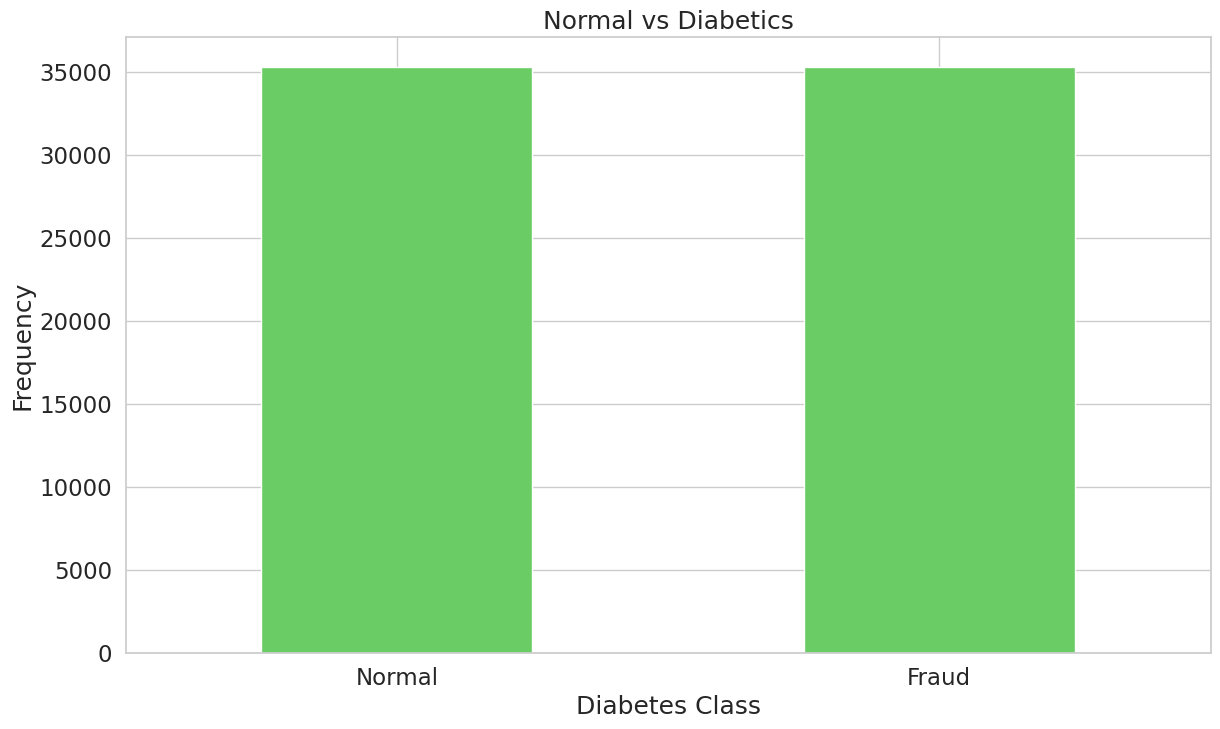

In [13]:
count_classes = pd.value_counts(df['Diabetes_binary'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Diabetics")
plt.xticks(range(2), LABELS)
plt.xlabel("Diabetes Class")
plt.ylabel("Frequency");

Наш набор данных очень сильно несбалансирован в пользу отрицательного (0, то есть нормального) класса. Это требует дальнейшего изучения данных

In [19]:
diabetesDF = df[df['Diabetes_binary'] == 1]
normalDF = df[df['Diabetes_binary'] == 0]

In [21]:
diabetesDF.shape

(35346, 22)

In [22]:
normalDF.shape

(35346, 22)

Давайте теперь посмотрим на сумму денег, задействованную в двух классах.

In [23]:
diabetesDF['BMI'].describe()

,BMI
count,35346.000000
mean,0.231907
std,0.085621
min,0.011628
25%,0.174419
50%,0.220930
75%,0.267442
max,1.000000


In [24]:
normalDF['BMI'].describe()

,BMI
count,35346.000000
mean,0.183372
std,0.071949
min,0.000000
25%,0.139535
50%,0.174419
75%,0.220930
max,1.000000


Graphically speaking

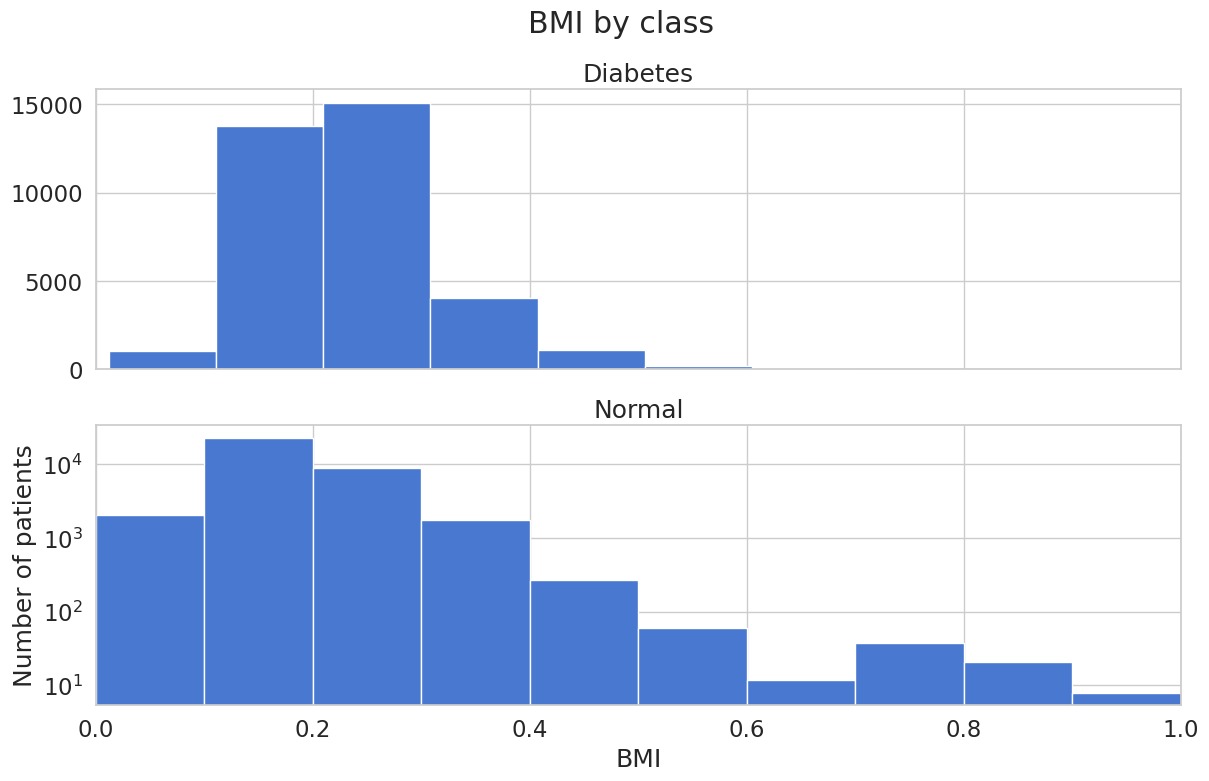

In [32]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('BMI by class')

ax1.hist(diabetesDF['BMI'])
ax1.set_title('Diabetes')

ax2.hist(normalDF['BMI'])
ax2.set_title('Normal')

plt.xlabel('BMI')
plt.ylabel('Number of patients')
plt.xlim((0, 1))
plt.yscale('log')
plt.show();

Влияет ли время транзакции на мошеннические транзакции?

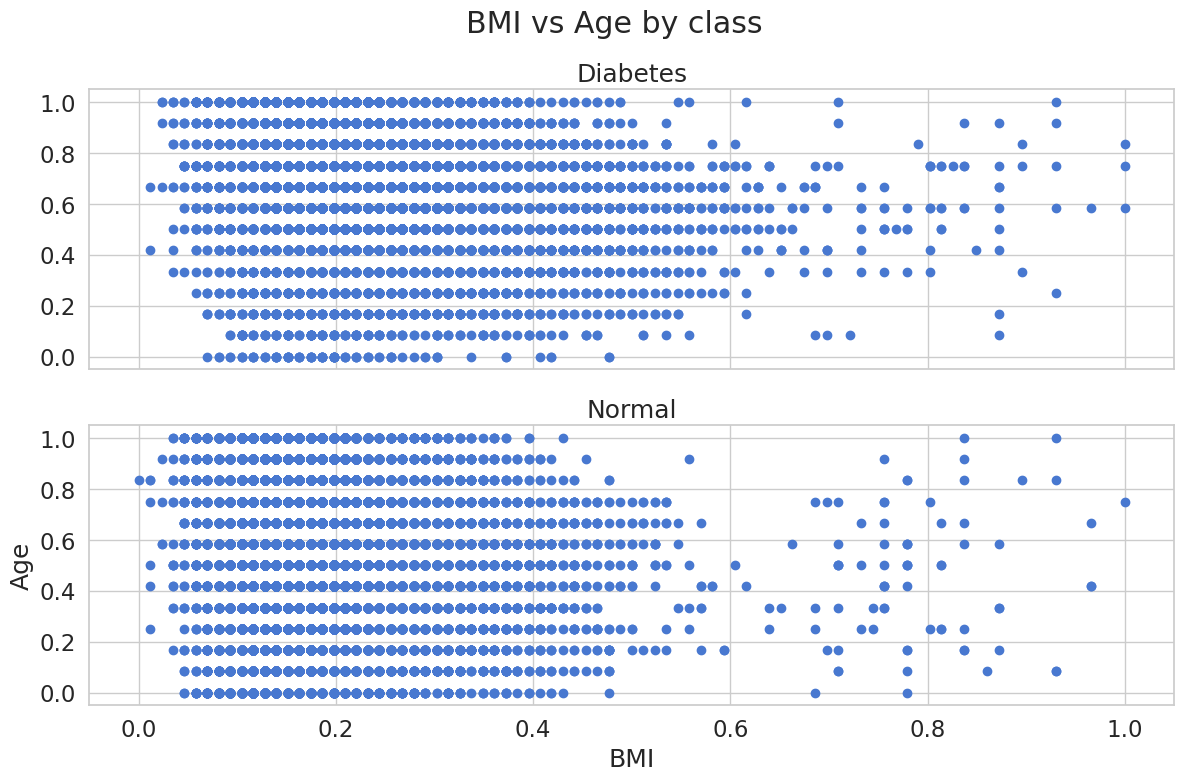

In [33]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('BMI vs Age by class')

ax1.scatter(diabetesDF['BMI'], diabetesDF['Age'])
ax1.set_title('Diabetes')

ax2.scatter(normalDF['BMI'], normalDF['Age'])
ax2.set_title('Normal')

plt.xlabel('BMI')
plt.ylabel('Age')
plt.show()

Таким образом, очевидно, что возраст не имеет никакого отношения к наличию диабета.

## Preprocessing

Поскольку, как показано выше, возраст не влияет на мошенническую деятельность, эта функция не будет способствовать обучению модели. Следовательно, мы можем отказаться от него.

In [34]:
transactionData = df.drop(['Age'], axis=1)

Также давайте стандартизируем Amount.

In [35]:
# transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1, 1))

### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только обычные транзакции, а в тестовом наборе данных будут как обычные, так и мошеннические транзакции.

In [37]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train['Diabetes_binary'] == 0]
X_train = X_train.drop(['Diabetes_binary'], axis=1)
#print(type(X_train))
y_test = X_test['Diabetes_binary']
X_test = X_test.drop(['Diabetes_binary'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


14139


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 14,7,7,20 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 20 узлов, соответствующих 20 функциям в элементе входных данных.

In [38]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 20),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [39]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [40]:
num_epochs = 100   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [41]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [42]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [43]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [44]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [45]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:0.1216
epoch [2/100], loss:0.0507
epoch [3/100], loss:0.0407
epoch [4/100], loss:0.0374
epoch [5/100], loss:0.0333
epoch [6/100], loss:0.0305
epoch [7/100], loss:0.0295
epoch [8/100], loss:0.0291
epoch [9/100], loss:0.0287
epoch [10/100], loss:0.0284
epoch [11/100], loss:0.0281
epoch [12/100], loss:0.0278
epoch [13/100], loss:0.0276
epoch [14/100], loss:0.0273
epoch [15/100], loss:0.0270
epoch [16/100], loss:0.0268
epoch [17/100], loss:0.0266
epoch [18/100], loss:0.0265
epoch [19/100], loss:0.0264
epoch [20/100], loss:0.0263
epoch [21/100], loss:0.0263
epoch [22/100], loss:0.0262
epoch [23/100], loss:0.0261
epoch [24/100], loss:0.0260
epoch [25/100], loss:0.0259
epoch [26/100], loss:0.0258
epoch [27/100], loss:0.0257
epoch [28/100], loss:0.0255
epoch [29/100], loss:0.0254
epoch [30/100], loss:0.0252
epoch [31/100], loss:0.0251
epoch [32/100], loss:0.0250
epoch [33/100], loss:0.0249
epoch [34/100], loss:0.0248
epoch [35/100], loss:0.0248
epoch [36/100], loss:0.0247
e

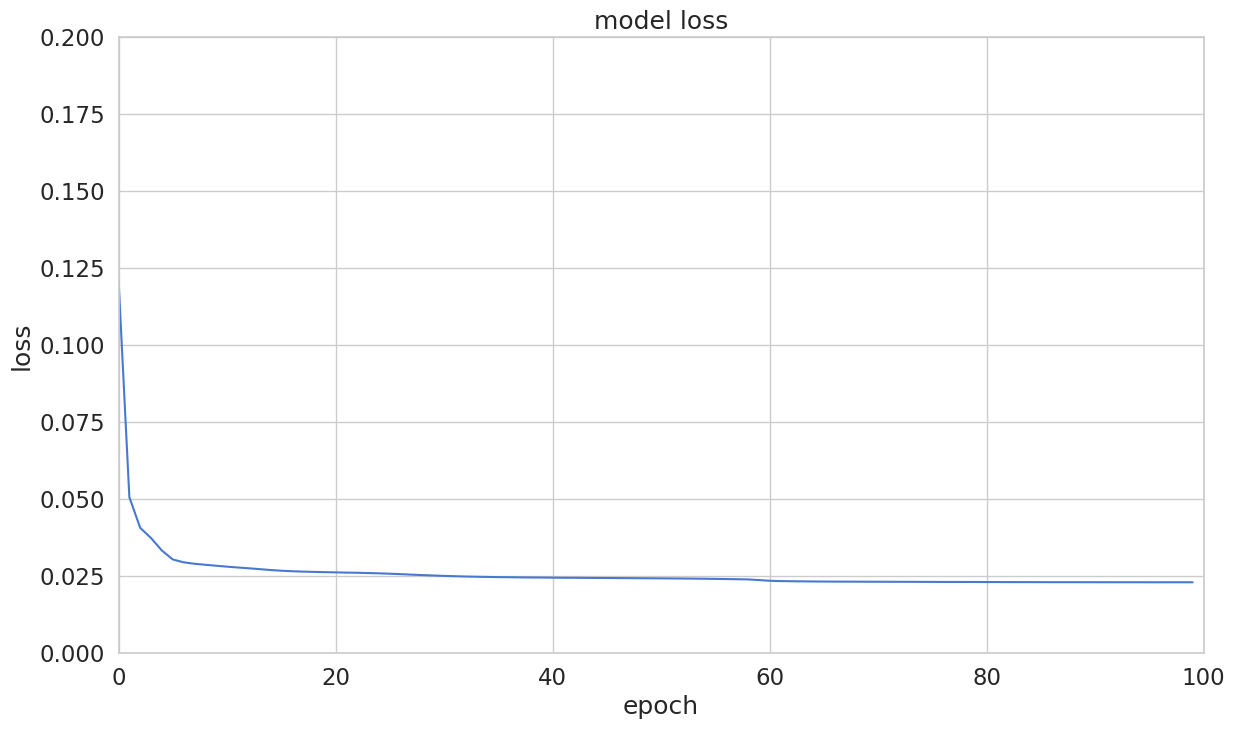

In [47]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0,0.2])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [48]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [49]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,14139.000000,14139.000000
mean,0.029563,0.498550
std,0.033075,0.500016
min,0.000443,0.000000
25%,0.005361,0.000000
50%,0.015229,0.000000
75%,0.046681,1.000000
max,0.233100,1.000000


# Reconstruction errors without Diabetes

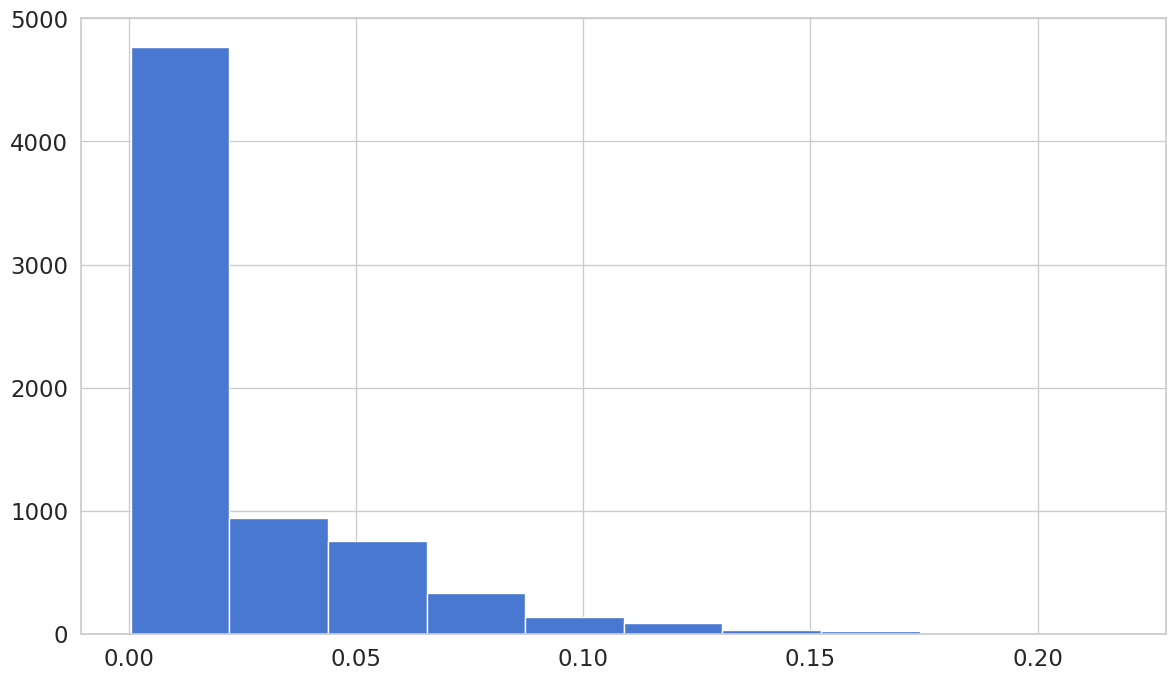

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Diabetes

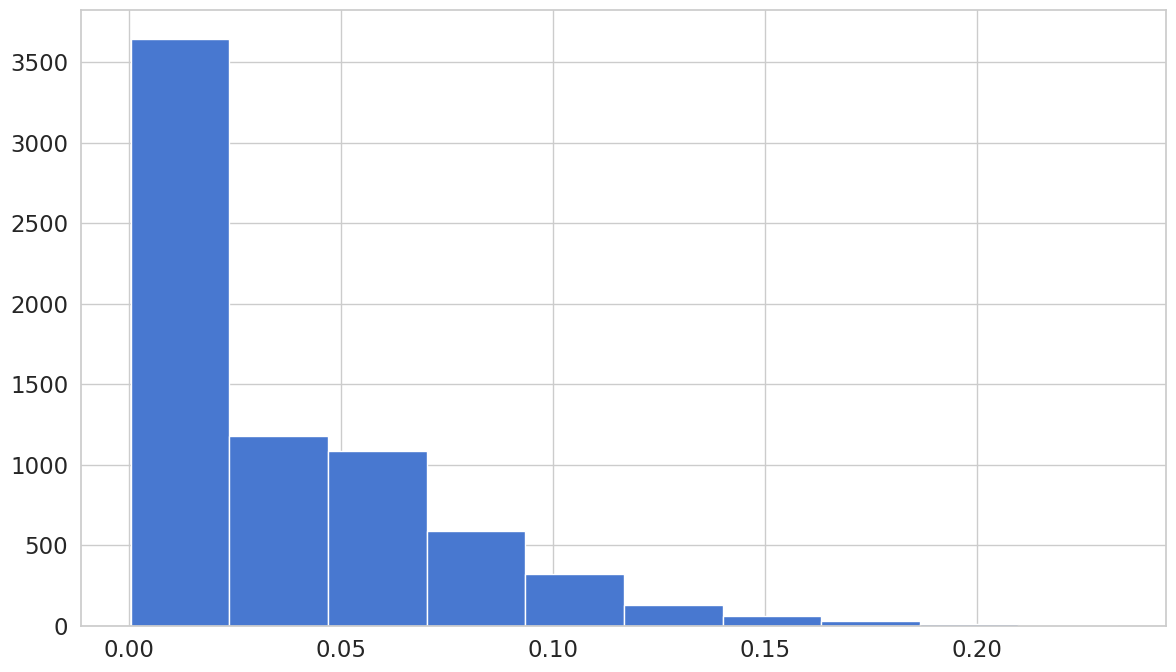

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

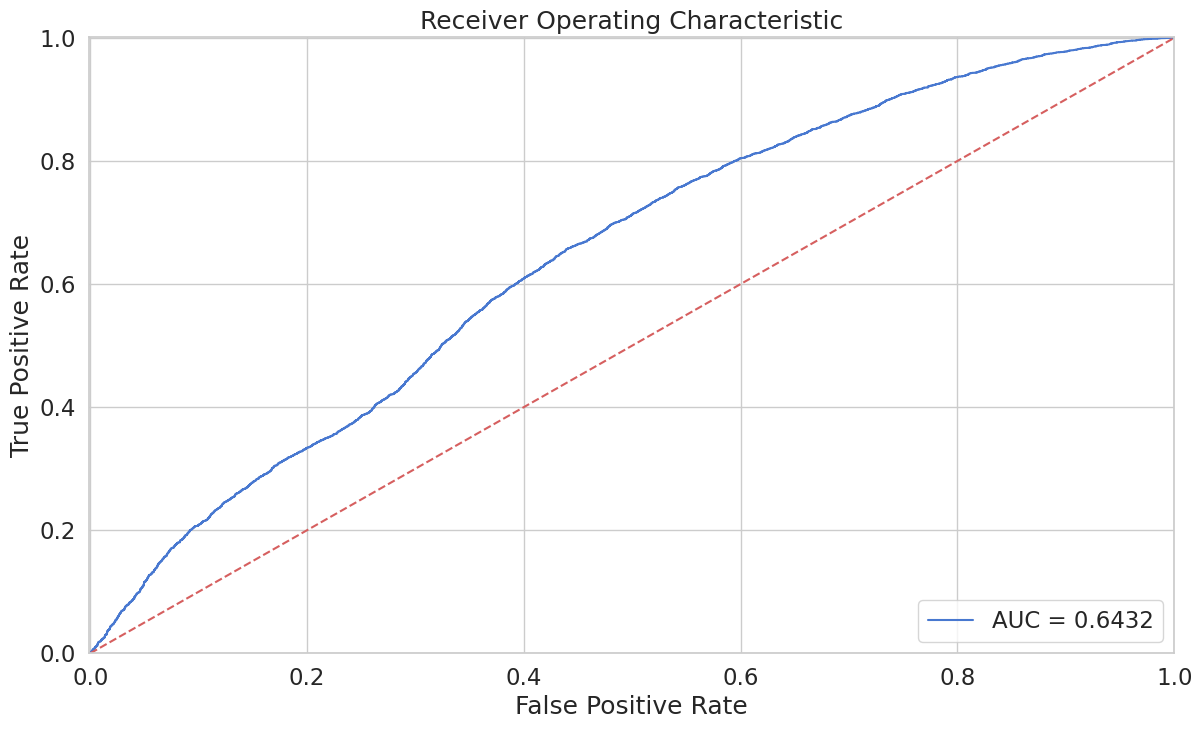

In [54]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

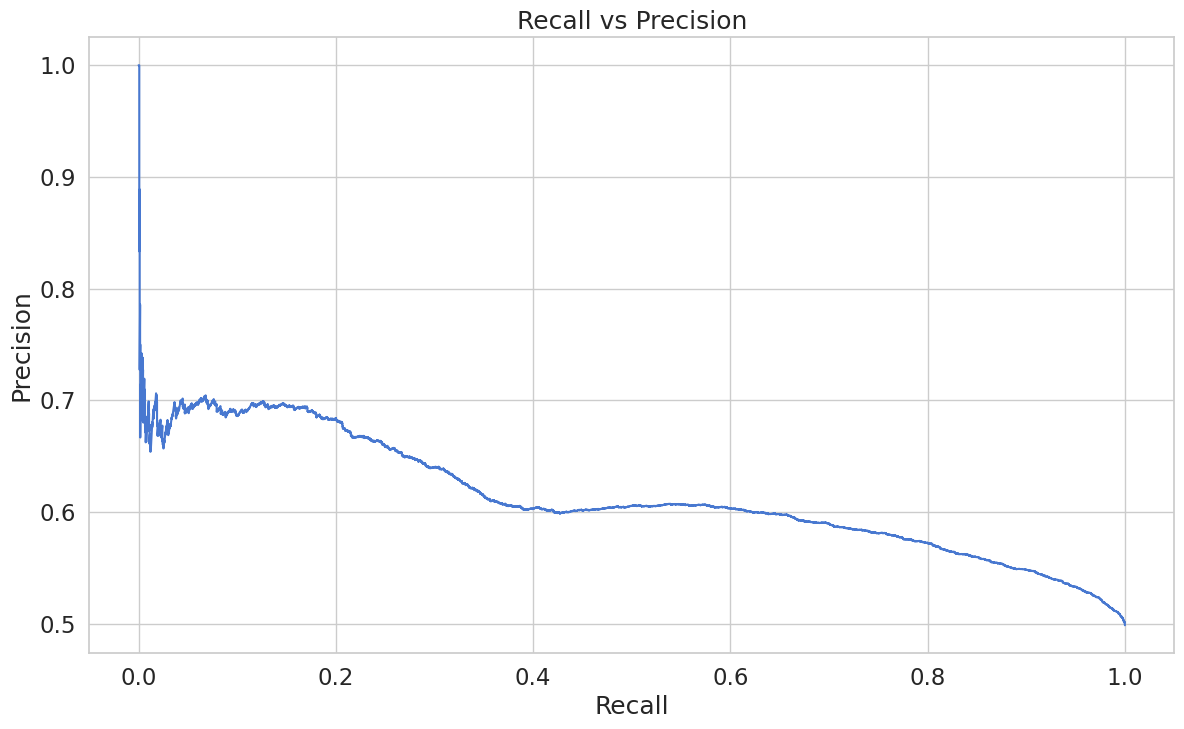

In [55]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

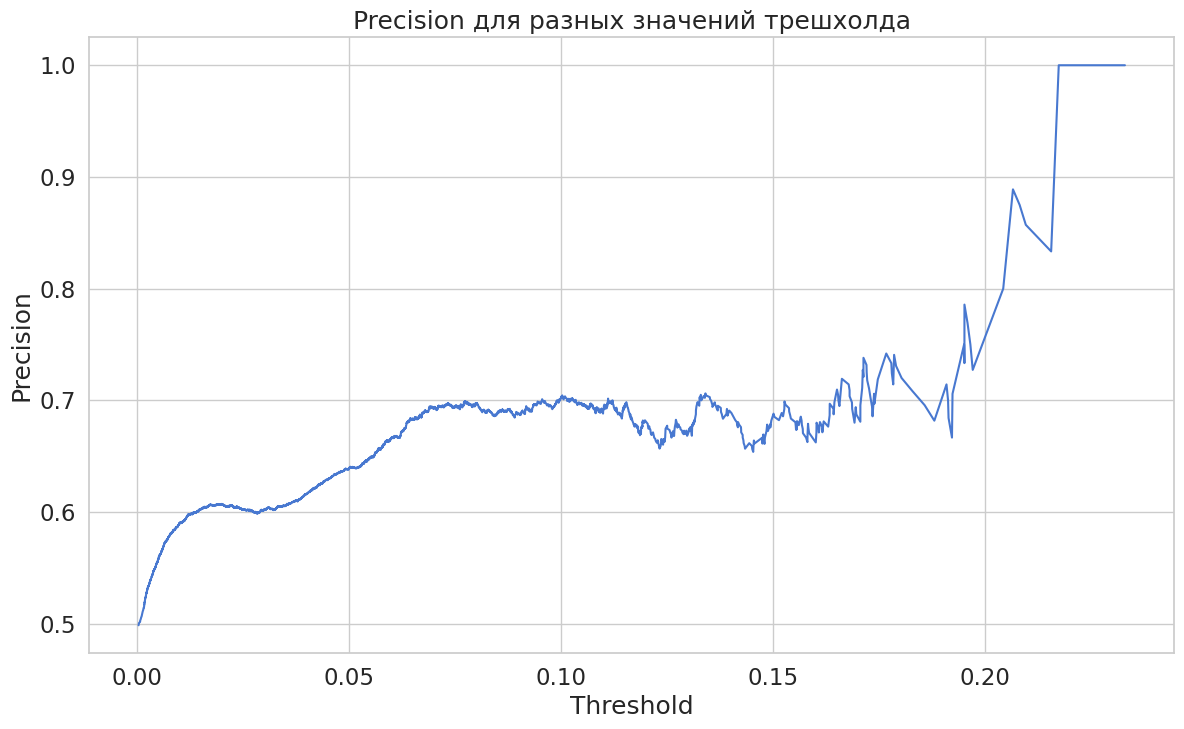

In [56]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


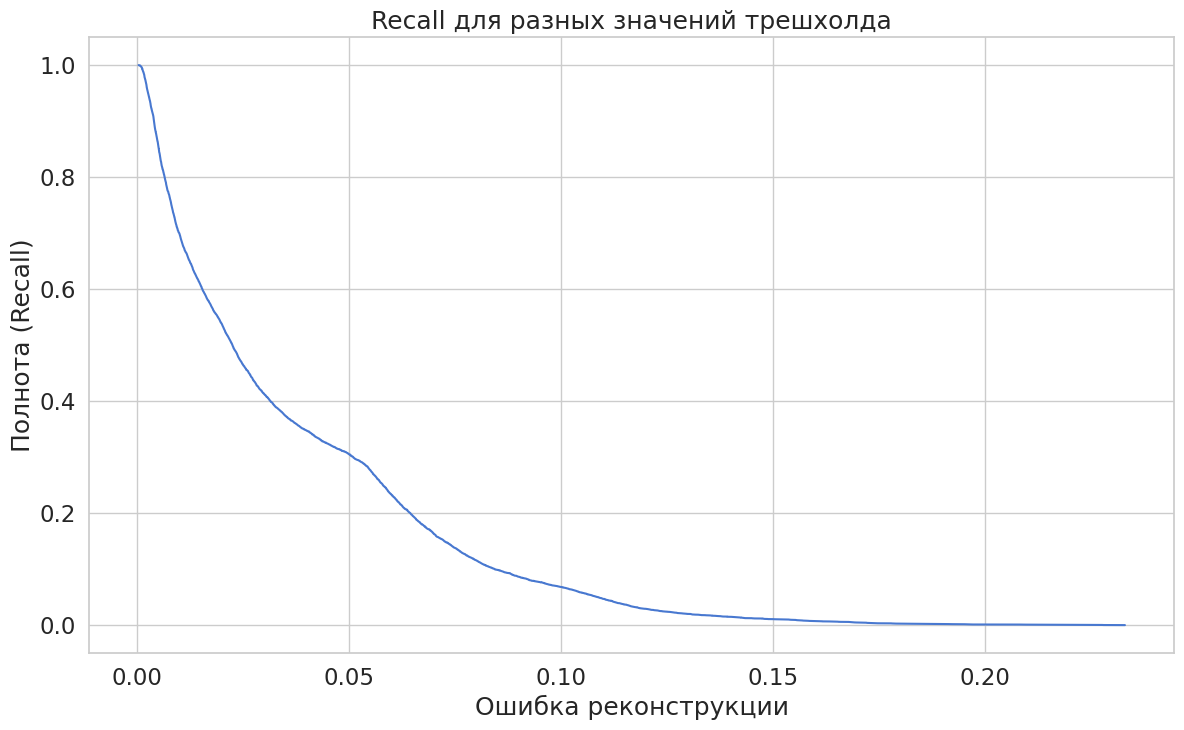

In [57]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [89]:
threshold = 0.005

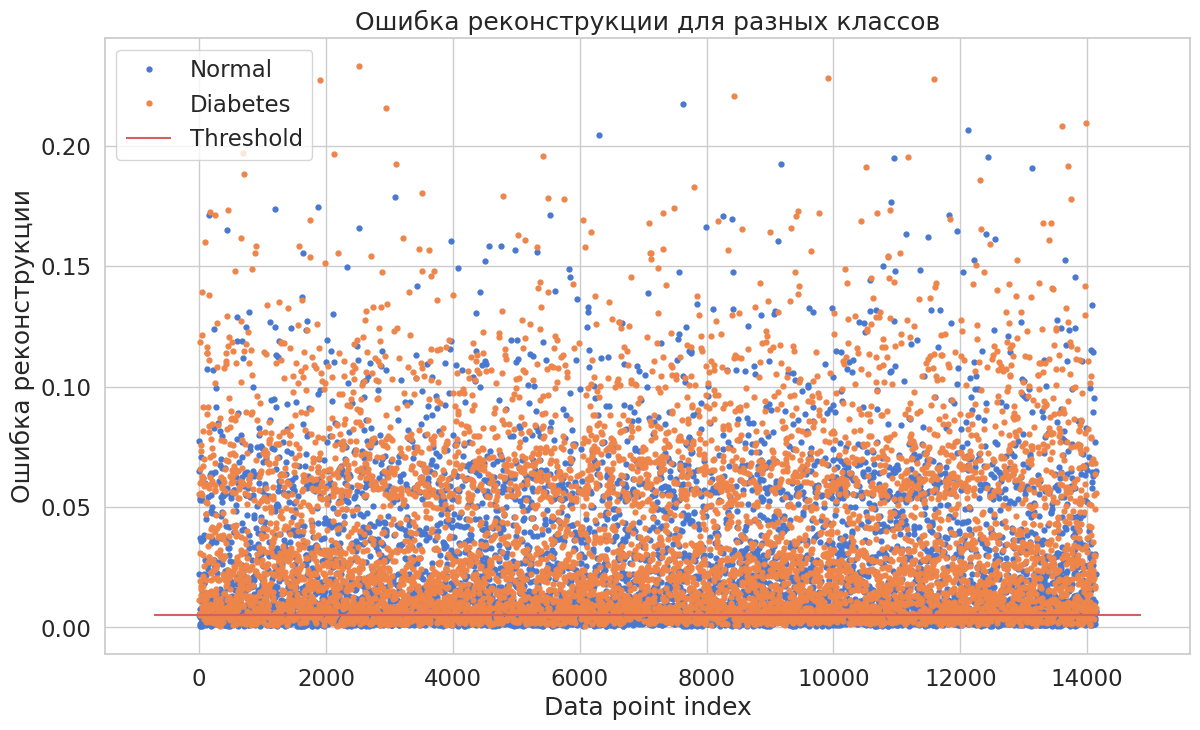

In [90]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Diabetes" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-91-11f70cc5c840>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


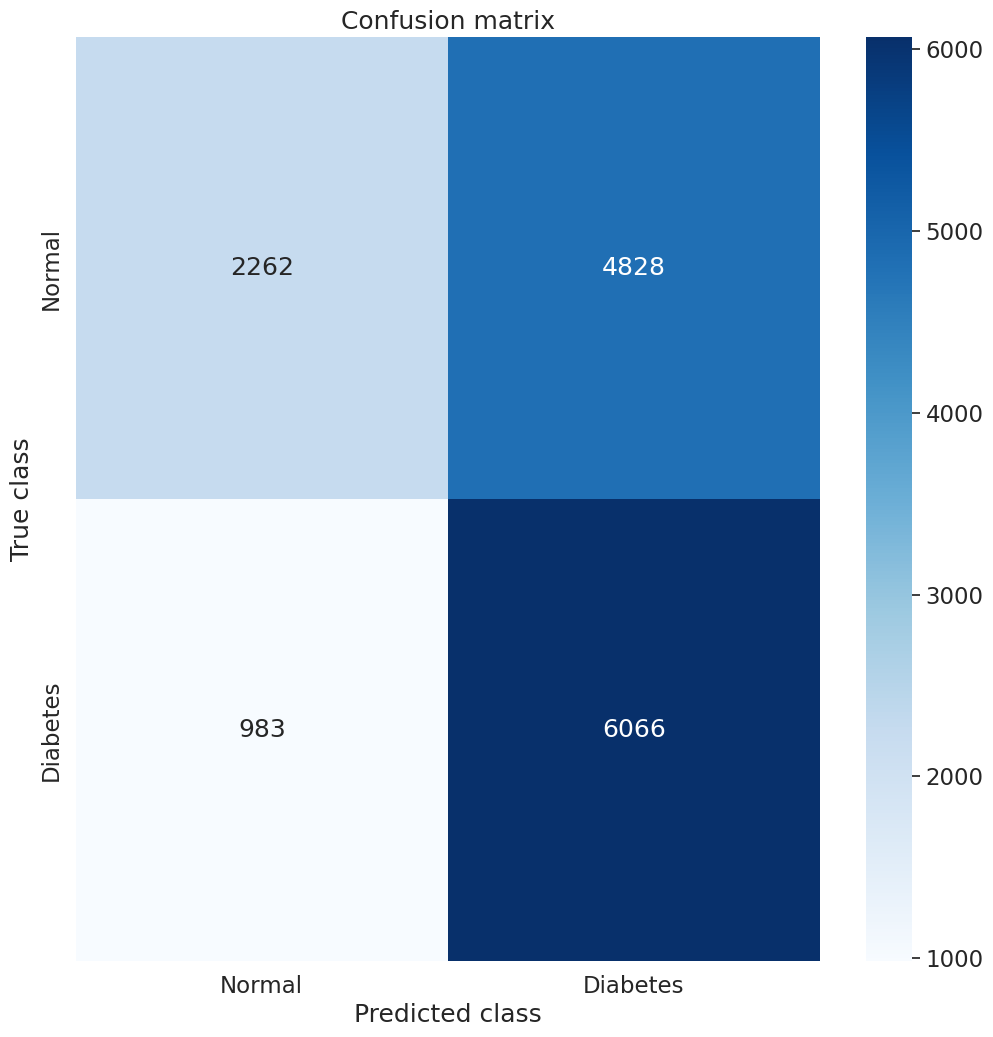

In [91]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель, похоже, выявляет множество случаев мошенничества. Но количество обычных транзакций, классифицируемых как мошенничество, действительно велико. Можно настроить порог здесь и там, чтобы получить лучшие результаты.

## Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.